In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
import random

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


## Helper fcns

In [4]:
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; 
        acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        f1_test_all=[]; prec_all=[]; rec_all=[]; auprc_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            #f1-score, prec and recall, auprc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            
            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            print('\nSubj %d, prec=%.3f, rec=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred)))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all)))
        
          


#             #compute Sens and Spec for current subject and classifier
#             if np.sum(yte==1)>0:                    
#                 Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
#             else:
#                 print('%s has no positive examples'%Data.Subject[test_index].unique())
#                 Sens = np.nan
#             if np.sum(yte==0)>0:
#                 Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
#             else:
#                 Spec = np.nan
#                 print('%s has no negative examples'%Data.Subject[test_index].unique())
#             Sens_all.append(Sens); Spec_all.append(Spec)
#             #compute accuracy
#             acc = sum(ypred==yte)/len(yte)
#             acc_all.append(acc)
        
        #mean across all subjects
#         print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
#         print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
#         print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
#         print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))
        
       
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [5]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

### CNN functions

In [6]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_eval(X_valid,y_valid):
    fig=plt.figure()
    fig.add_subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    fig.add_subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('accuracy')
    plt.legend(['train','test'],loc='best')

    #performance eval
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    y_score = model.predict(X_valid)[:,1]
    
    f1_test=f1_score(y_true,y_pred)
    Prec = precision_score(y_true,y_pred)
    Rec = recall_score(y_true,y_pred)
    Spec = sum((y_pred==0) & (y_true==0))/sum(y_true==0)

    precision, recall, _ = precision_recall_curve(y_true,y_score)
    auprc = auc(recall,precision)
    auroc = roc_auc_score(y_true,y_score)

    print('f1_test=%.3f, Prec=%.3f, Rec=%.3f, Spec=%.3f, auprc=%.3f, auroc=%.3f'%(f1_test,Prec,Rec,Spec,auprc,auroc))
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
#     print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

    #compute ROC at fixed fpr (to plot error bars)
    fpr=np.linspace(0,1,101); tpr=[]
    nscores = np.sort(np.column_stack((y_score[y_true==0],y_true[y_true==0])),axis=0)
    neg_counts = sum(y_true==0)
    for f in fpr:
        ind = neg_counts-int(neg_counts*f)-1
        t = (nscores[ind])[0]
        if f==1:
            t = 0
        tpr_t = sum(y_score[y_true==1]>t) / sum(y_true==1)
        tpr.append(tpr_t) 

    fpr = np.asarray(fpr); tpr = np.asarray(tpr)

    return f1_test,Rec,Spec,auprc,auroc,fpr,tpr


def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(acc,axis=0)
    s = np.std(acc,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(5,10):
            print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

def buildCNN(win_len,dim):
    num_classes = 2  

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
#     model.add(BatchNormalization()) 
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
#     model.summary()
        
    return model

def buildCNN_reg(win_len,dim):

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
        
    return model

### Load data

## CNN on rawdata

In [31]:
# data = pd.read_hdf('./FeatureMatrix/DataRawClipsUnfiltered.hdf5')
# data = pd.read_hdf('./FeatureMatrix/DataRawClips.hdf5') #HP Filtered Accelerometer
data = pd.read_hdf('./FeatureMatrix/DataRawFullDataset.hdf5') #unfiltered - Dataset w all subjects

In [32]:
data.head(3)

,Subject,Visit,Task,Location,Bradykinesia,Tremor,Dyskinesia,acc_xyz,gyr_xyz
0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.38654154268711416, -0.98970016021973, 0.21...","[[2.410925459678083, 28.71747920958251, 1.8005..."
1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[-0.03558403906309593, -1.087968261234455, 0....","[[-54.41367208361953, 12.970168612191856, 110...."
2,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.23297474631876106, -0.8850843060959792, 0....","[[-45.25825894560171, 7.660028992141633, 38.78..."


In [33]:
len(data)

35229

In [34]:
data.Visit.unique()

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150',
       '4 Weeks'], dtype=object)

In [35]:
len(data.Subject.unique())

20

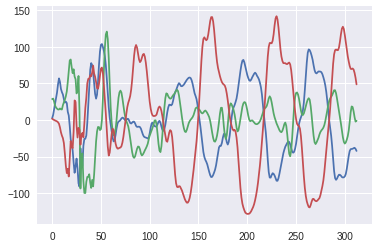

In [36]:
ax=plt.plot(data.gyr_xyz.values[0])

In [37]:
data.columns[7:]

Index(['acc_xyz', 'gyr_xyz'], dtype='object')

In [38]:
data[data.Dyskinesia >0].Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #5: Alternating Hand Movements', 'Motor #9: Nuts and Bolts',
       'Motor #4: Finger to Nose', 'Motor #6: Sit to Stand',
       'Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels'], dtype=object)

In [39]:
# data[data.Visit=='1 Month'].Subject
# data.loc[(data.Subject==1004)&(data.Visit=='1 Month')]
# data.loc[(data.Subject==1004)&(data.Visit=='4 Weeks')]

In [40]:
#get rid of subj 1020 and of 1M of data in subj 1004
data = data.loc[data.Subject!=1020]
data = data.loc[data.Visit!='1 Month']

In [17]:
#remove data from visit 7 (day 2, 4 weeks)
data = data.loc[data.Visit!='4 Weeks']

In [41]:
#unpack clips, scores, subj and task data
le = LabelEncoder()
acc = data.acc_xyz.values
gyr = data.gyr_xyz.values
scores_brady = data.Bradykinesia
scores_tremor = data.Tremor
scores_dysk = data.Dyskinesia
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)

In [42]:
# #last 5 subjects have 6 visits only
# for s in data.Subject.unique():
#     nv = data.loc[data.Subject==s,'Visit'].unique()
#     print(s,len(nv))

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: Mean of empty slice


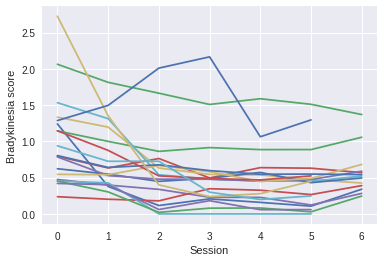

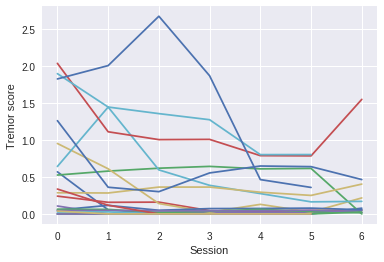

In [43]:
plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Bradykinesia'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Bradykinesia score')

plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Tremor'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Tremor score')


Plot clips with symptoms

In [106]:
dataP=data[data.Bradykinesia>1]
dataN=data[data.Bradykinesia==0]

Subject                                                      1004
Visit                                            2 Weeks: Time 90
Task                             Motor #3: Walking while Counting
Location                                        dorsal_hand_right
Bradykinesia                                                    0
Tremor                                                          0
Dyskinesia                                                      2
acc_xyz         [[0.3250171663996335, 1.0161898222323948, 0.01...
gyr_xyz         [[63.93530174715806, -17.66994735637445, 31.21...
Name: 8, dtype: object


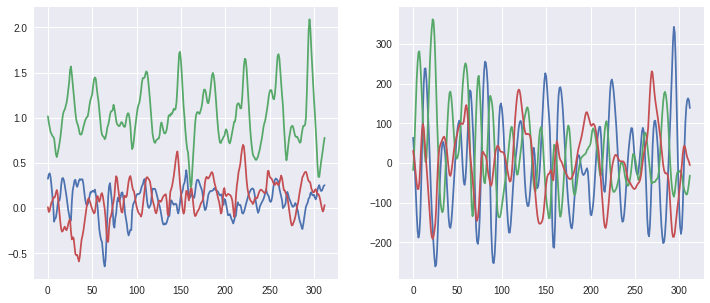

In [107]:
idx = np.random.choice(np.arange(len(dataP)),size=1)
d=dataN.iloc[int(idx)]
print(d)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(d.acc_xyz)
fig.add_subplot(122)
plt.plot(d.gyr_xyz)

In [16]:
# data['acclen']=data.apply()

In [18]:
subj

array([ 0,  0,  0, ..., 13, 13, 13])

### Resample data

In [44]:
#check clips with less than 313 samples and resample
la=[]; lg=[]
for i in range(len(acc)):
    la.append(acc[i].shape[0])
    lg.append(gyr[i].shape[0])

print(np.unique(lg))

#resample all clips to 313 samples (62.5 Hz)
# accres = []
num = 313
accres = np.zeros((len(acc),num,3) )
gyrres = np.zeros((len(gyr),num,3) )
for i in range(len(acc)):
    if len(acc[i]<num):
        accres[i,:,0] = resample(acc[i][:,0],num)
        accres[i,:,1] = resample(acc[i][:,1],num)
        accres[i,:,2] = resample(acc[i][:,2],num)
    else: 
        accres[i,:,:] = acc[i].copy()
        
    if len(gyr[i]<num):
        gyrres[i,:,0] = resample(gyr[i][:,0],num)
        gyrres[i,:,1] = resample(gyr[i][:,1],num)
        gyrres[i,:,2] = resample(gyr[i][:,2],num)
    else:
        gyrres[i,:,:] = acc[i].copy()

[297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313]


In [45]:
acc = accres
gyr = gyrres

In [46]:
def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    x = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(x,axis=0)
    s = np.std(x,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(0,5):
            print(np.mean(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

In [47]:
accn = stdclipdata(acc,False)
gyrn = stdclipdata(gyr,False)

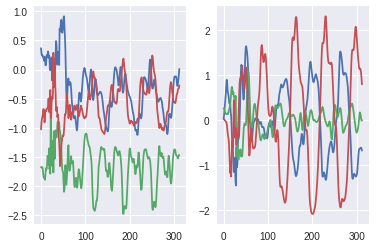

In [48]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(accn[0])
fig.add_subplot(122)
plt.plot(gyrn[0])

In [49]:
#save normalized clips
X = np.concatenate((accn,gyrn),axis=-1) #use acc and gyro data

In [50]:
np.save('Trainclips_FullDataset',X)

Train CNN using LOSO CV

## Train CNN on bradykinesia data
* accelerometer + gyro clips

In [80]:
!ls

AlterTimestamps.ipynb	     Models_GPU.ipynb
Clipsfiltered.hdf5	     PreprocessFcns.py
DataCleaning.ipynb	     __pycache__
DataPreprocessor2.ipynb      README.md
DataPreprocessorDebug.ipynb  Results
DataPreprocessor.ipynb	     ScoresAnalysis.ipynb
FeatureMatrix		     TaskVisualizer.ipynb
FFT_example.ipynb	     Trainclips_FullDataset.npy
Legacy Folder		     Trainclips.npy
Models			     Trainclips_unfiltered.npy
Models_GPU-AllLocs.ipynb


In [54]:
X = np.load('Trainclips_FullDataset.npy')
y = scores_brady.values
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)
print(X.shape)
print(y.shape)
print(np.unique(subj))
print(np.unique(visit))

(33809, 313, 6)
(33809,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[0 1 2 3 4 5 6]


In [55]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [56]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(32268, 313, 6)
(32268,)
(32268,)
(32268,)
(32268,)


In [57]:
yreg = y.copy()
yclass = y.copy()
yclass[y>0] = 1

In [58]:
#binarize labels
y[y>0] = 1

### Train Regression model

Need to check callbacks http://parneetk.github.io/blog/neural-networks-in-keras/

In [134]:
def rmse_K(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred-y_true),axis=-1))


In [135]:
from keras import metrics
from keras.callbacks import EarlyStopping

reshaping data for different models ...
CNN
X_train = 
(22593, 1, 313, 6)
model training ... - eval on visit [6]
Train on 22593 samples, validate on 3607 samples
Epoch 1/10
22593/22593 [==============================] - 9s - loss: 0.8877 - mean_squared_error: 0.8877 - val_loss: 0.9390 - val_mean_squared_error: 0.9390
Epoch 2/10
22593/22593 [==============================] - 9s - loss: 0.7631 - mean_squared_error: 0.7631 - val_loss: 0.8091 - val_mean_squared_error: 0.8091
Epoch 3/10
22593/22593 [==============================] - 9s - loss: 0.6556 - mean_squared_error: 0.6556 - val_loss: 0.6358 - val_mean_squared_error: 0.6358
Epoch 4/10
22593/22593 [==============================] - 9s - loss: 0.5712 - mean_squared_error: 0.5712 - val_loss: 0.5515 - val_mean_squared_error: 0.5515
Epoch 5/10
22593/22593 [==============================] - 9s - loss: 0.5054 - mean_squared_error: 0.5054 - val_loss: 0.5243 - val_mean_squared_error: 0.5243
Epoch 6/10
22593/22593 [=============================

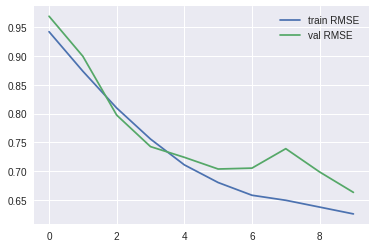

In [137]:
y = yreg.copy()

#fix random seed to reproduce results
seed=8
np.random.seed(seed)

#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    current_visit = np.unique(visit[test_index])
    task_subj = task[test_index] #tasks for current visit
    
    #only run on one visit
    if current_visit < 6:
        continue

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN_reg(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    earlystop = EarlyStopping(monitor='mean_squared_error',min_delta=0.005,patience=3)
    callbacks_list = [earlystop]
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])
    hist=model.fit(X_train, y_train, batch_size, epochs=10, shuffle=True, validation_data=(X_valid,y_valid),
                  callbacks=callbacks_list)
    
    plt.plot(np.sqrt(hist.history['mean_squared_error']))
    plt.plot(np.sqrt(hist.history['val_mean_squared_error']))
    plt.legend(['train RMSE','val RMSE'])


Does our model do better than the average model?

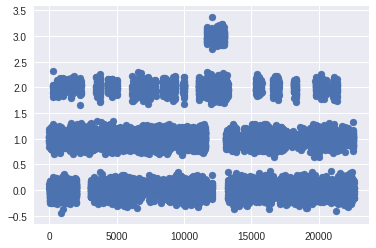

In [138]:
plt.scatter(x=np.arange(len(y_train)),y=y_train+ 0.1*np.random.randn(len(y_train),))

In [139]:
np.unique(yreg[test_index])

array([0., 1., 2., 3.])

In [140]:
#RMSE of model always predicting the mean score across all visits
ypmean = np.mean(y_train)
print('MSE avg model = %.3f'%(np.mean((yreg[test_index]-ypmean)**2)))
print('RMSE avg model = %.3f'%(np.sqrt(np.mean((yreg[test_index]-ypmean)**2))))

MSE avg model = 0.566
RMSE avg model = 0.753


Our model is slightly better

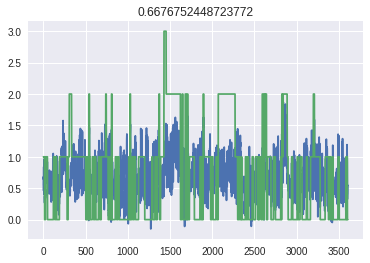

In [144]:
ypred = model.predict(X_valid)
plt.plot(ypred)
plt.plot(y_valid)
plt.title((np.mean((ypred-y_valid)**2)))

Unclear why RMSE is different from what returned during training (0.4398)

In [145]:
indp = np.where(y_valid>0)[0]
Xpos = X_valid[indp,:,:,:]
ypos = y_valid[indp]

In [146]:
ypred = model.predict(Xpos)

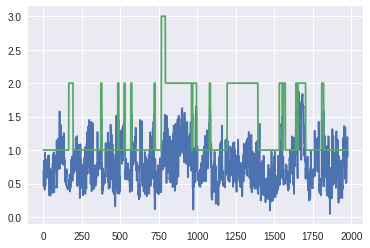

In [147]:
plt.plot(ypred)
plt.plot(ypos)

In [148]:
np.sqrt(np.mean((ypred-ypos)**2))

0.7867969820129594

## Data Augmentation
**Perform Data Augmentation - Random Rotations**

In [26]:
#rotate vector p around axis (0=x, 1=y, 2=z(orthogonal to sensor plane))
#vector p is 3x1"
def rot(th,p,axis=2):
    if axis == 0: #x-axis rot
        R = np.array([[1,0,0],[0, np.cos(th), -np.sin(th)],[0, np.sin(th), np.cos(th)]])
    if axis ==1: #y-axis rot
        R = np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])    
    if axis==2: #z-axis rot
        R = np.array([[np.cos(th), -np.sin(th), 0],[np.sin(th), np.cos(th), 0],[0,0,1]])

    pR = np.matmul(R,p)
    return pR,R

In [27]:
pi = np.pi
xR = []
xacc = X[:,:,:3]
for i in range(xacc.shape[0]):
    xR.append(rot(pi/2,xacc[i].T))

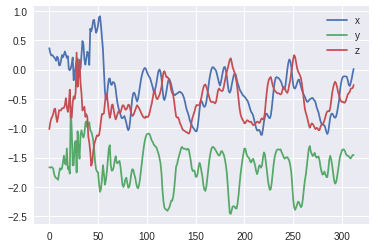

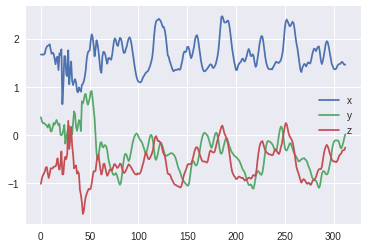

In [28]:
plt.plot(xacc[0,:,:3])
plt.legend(('x','y','z'))
plt.figure()
plt.plot(xR[0][0].T)
plt.legend(('x','y','z'))

In [26]:
# th= np.pi/2
# # X_train[0,:,:,3:].squeeze().shape
# xaccR = rot(th,X_train[0,:,:,:3].squeeze().T)[0].T
# xgyrR = rot(th,X_train[0,:,:,3:].squeeze().T)[0].T
# print(xaccR.shape)
# xaccR = np.expand_dims(xaccR,axis=0)
# xgyrR = np.expand_dims(xgyrR,axis=0)
# XR = np.concatenate((xaccR,xgyrR),axis=2)
# print(XR.shape)
# print(X_train.shape)
# X_train[0,:,:,:] = XR
# # plt.plot(xaccR)
# # plt.figure()
# # plt.plot(X_train[0,:,:,3:].squeeze())
# # plt.legend(('x','y','z'))


Below the class to implement the data generator in Keras. Re-adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

In [51]:
#test for data shift (overlapping windows)
# x0 = X_train[0,:,:,:]
# x1 = X_train[1,:,:,:]
# x = np.concatenate((x0,x1),axis=1)
# ind0 = int((0.5*np.random.rand(1)+0.25)*313) #pick random start time in clip 0
# print(ind0)
# Xnew = x[:,ind0:ind0+313] 
# plt.plot(x[0])
# plt.figure()
# plt.plot(Xnew[0])

In [53]:
#create Data Generator Class to apply random rotations to training data

class DataGenerator(object):

    #class init fcn
    def __init__(self, dim_x = 1, dim_y=313, dim_z = 6, batch_size=512, shuffle=True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size= batch_size
        self.shuffle = shuffle
    
    #Acutal generator method. Its structure is an infinite loop that goes through the dataset 
    #and outputs one batch at a time.
    def generate(self, X_train, labels):
         # Infinite loop
        while 1:
            # Generate batches
            indexes = np.arange(len(labels))
            #shuffle data
            if self.shuffle == True:
                np.random.shuffle(indexes)
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                #Find list of IDs for current batch
                list_IDs_temp = [indexes[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                #generate data (rotated)
                X,y = self.__data_generation(X_train,labels,list_IDs_temp)

                yield X,y


    #Private method: generates a random order of exploration for a given set of list_IDs (train indices)    
    def __get_exploration_order(self, list_IDs):
        '  Find exploration order'
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes


    #outputs batches of data. The private method in charge of this task is called __data_generation and
    #only needs to know about the list of IDs included in batches as well as their corresponding labels.
    def __data_generation(self, X_train, labels, list_IDs_temp):
        num_classes = 2
        'Generates data of batch_size samples' # X : (n_samples, 1, time, n_channels)
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size), dtype=int)

        #generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #store batch data - DO NOT AUGMENT
#             X[i,:,:,:] = X_train[ID,:,:,:]

            #random rotation for current batch
            rax = np.random.randint(0,3) #select random axis to rotate around
            a = 5; b = 5 #min,max rotation (degrees)
            th=((b-a)*np.random.rand(1)+a)[0] #pick random angle
            th = np.pi*th/180
            xaccR = rot(th,X_train[ID,:,:,:3].squeeze().T,axis=rax)[0].T
            xgyrR = rot(th,X_train[ID,:,:,3:].squeeze().T,axis=rax)[0].T
            xaccR = np.expand_dims(xaccR,axis=0)
            xgyrR = np.expand_dims(xgyrR,axis=0)
            X[i,:,:,:] = np.concatenate((xaccR,xgyrR),axis=2)
            
            #generate new clip by overlapping 2 consecutive clips (shuffle must be set to False)
            if self.shuffle == False:
                x0 = X[i-1,:,:,:]
                x1 = X[i,:,:,:]
                x = np.concatenate((x0,x1),axis=1)
                ind0 = int((0.5*np.random.rand(1)+0.25)*self.dim_y) #pick random start time in clip 0
                Xnew = x[:,ind0:ind0+self.dim_y] 
                X[i,:,:,:] = Xnew
            
            #multiplicative noise (scaling)
            X[i,:,:,:] = X[i,:,:,:]*(1+0.05*np.random.randn(1)[0])

            #store labels
            y[i] = labels[ID]

        return X, keras.utils.to_categorical(y,num_classes)




### LOVO w Data augmentation

reshaping data for different models ...
CNN
X_train = 
(27148, 1, 313, 6)
model training ... - eval on visit [0]
Epoch 1/30
53/53 [==============================] - 3s - loss: 0.6988 - acc: 0.5347 - val_loss: 0.6875 - val_acc: 0.6215
Epoch 2/30
53/53 [==============================] - 3s - loss: 0.6632 - acc: 0.6066 - val_loss: 0.6590 - val_acc: 0.6713
Epoch 3/30
53/53 [==============================] - 2s - loss: 0.6284 - acc: 0.6519 - val_loss: 0.6310 - val_acc: 0.6729
Epoch 4/30
53/53 [==============================] - 2s - loss: 0.6043 - acc: 0.6763 - val_loss: 0.5728 - val_acc: 0.7393
Epoch 5/30
53/53 [==============================] - 3s - loss: 0.5892 - acc: 0.6911 - val_loss: 0.5815 - val_acc: 0.7201
Epoch 6/30
53/53 [==============================] - 3s - loss: 0.5732 - acc: 0.7006 - val_loss: 0.5695 - val_acc: 0.7303
Epoch 7/30
53/53 [==============================] - 2s - loss: 0.5644 - acc: 0.7097 - val_loss: 0.5680 - val_acc: 0.7164
Epoch 8/30
53/53 [======================

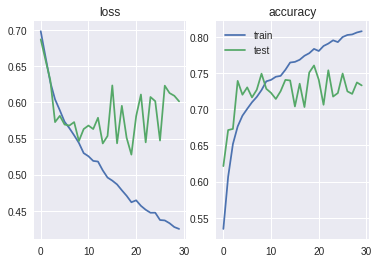

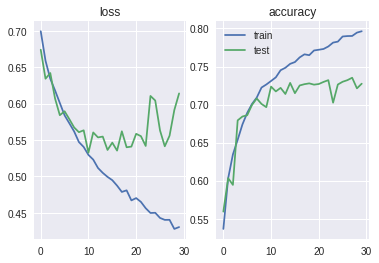

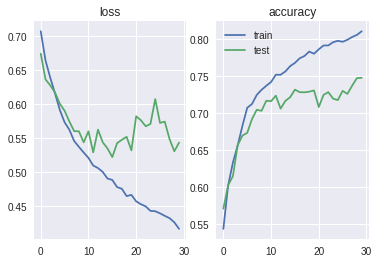

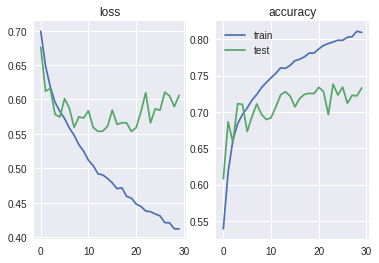

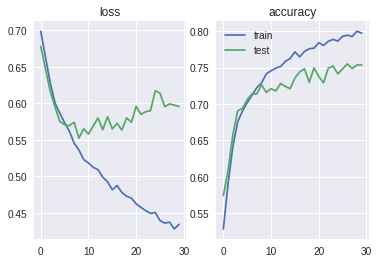

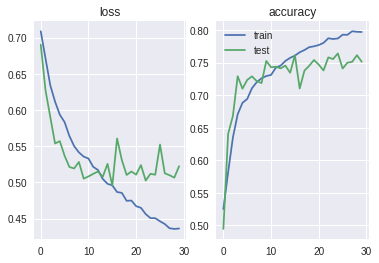

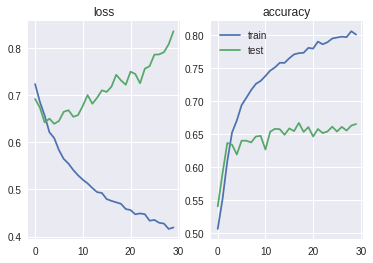

In [59]:
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

#specifying hyper-parameters
batch_size = 512 
num_classes = 2  
rec_task = pd.DataFrame()
params = {'dim_x':1, 'dim_y':313, 'dim_z':6, 'batch_size':batch_size, 'shuffle':True} #generator class params

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(visit[test_index])
    
#     if current_visit != 0:
#         continue
        
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 30
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    #Initialize DataGenerator object
    trainIDs = list(np.arange(X_train.shape[0]))
    training_generator = DataGenerator(shuffle=True).generate(X_train,y_train)

    hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                            validation_data=(X_valid,y_valid),verbose=1)
    #metrics
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
  

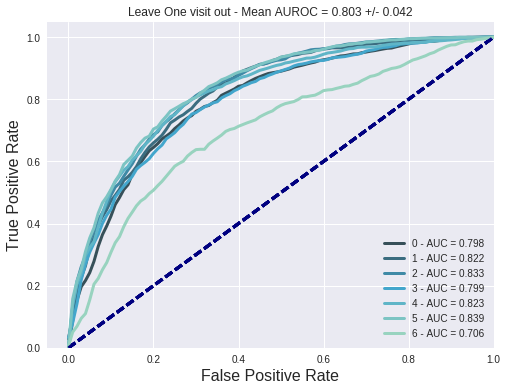

In [60]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(aurocall)):
    
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))